# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from sklearn import preprocessing as skp

In [2]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']


### if we want to downsample to only take a few classes into account

In [3]:
downsample = False

In [4]:
def select_classes_only(X, Y, classes):
    ix = np.in1d(Y, classes)
    
    X = X[ix]
    Y = Y[ix]
    
    d = dict(zip(np.unique(Y), range(len(classes))))
    for key,value in d.items():
        Y[Y == key] = value
    #y_train = np.asarray([d[x] for x in y_train])
    return X,Y

if(downsample == True):
    selected_classes = [1,2,4]
    X_train, y_train = select_classes_only(X_train, y_train, selected_classes)
    X_test, y_test = select_classes_only(X_test, y_test, selected_classes)


In [5]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(np.unique(np.concatenate((y_train,y_test),axis=0)))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Randomize data

In [6]:
def shuffle_together(x,y):
    assert len(x) == len(y)
    p = np.random.permutation(len(x))
    return x[p],y[p]

X_train, y_train = shuffle_together(X_train, y_train)


In [7]:
y_train.shape

(39209,)

### Create validation set

In [8]:
def create_validation_set(X, Y, validation_percentage):
    training_sample_size = X.shape[0]
    idx_split = int(training_sample_size*(1-validation_percentage))
    X_v = X[idx_split:]
    X_t = X[:idx_split]
    y_v = Y[idx_split:]
    y_t = Y[:idx_split]
    return X_v, X_t, y_v, y_t

X_valid, X_train, y_valid, y_train = create_validation_set(X_train, y_train, validation_percentage = .3)

print('Trianing set label:', y_train.shape, ' Features:', X_train.shape)
print('Validation set label:', y_valid.shape, ' Features:', X_valid.shape)
print('Test set label:', y_test.shape, ' Features:', X_test.shape)


Trianing set label: (27446,)  Features: (27446, 32, 32, 3)
Validation set label: (11763,)  Features: (11763, 32, 32, 3)
Test set label: (12630,)  Features: (12630, 32, 32, 3)


### Data exploration visualization

### number of example from each class
same distribution of classes for train and test

{0: 150, 1: 1552, 2: 1566, 3: 981, 4: 1403, 5: 1311, 6: 281, 7: 1001, 8: 1014, 9: 1009, 10: 1352, 11: 940, 12: 1511, 13: 1532, 14: 553, 15: 437, 16: 282, 17: 790, 18: 832, 19: 144, 20: 256, 21: 228, 22: 287, 23: 368, 24: 195, 25: 1051, 26: 417, 27: 163, 28: 380, 29: 175, 30: 314, 31: 543, 32: 154, 33: 482, 34: 293, 35: 840, 36: 274, 37: 152, 38: 1452, 39: 202, 40: 240, 41: 162, 42: 177}


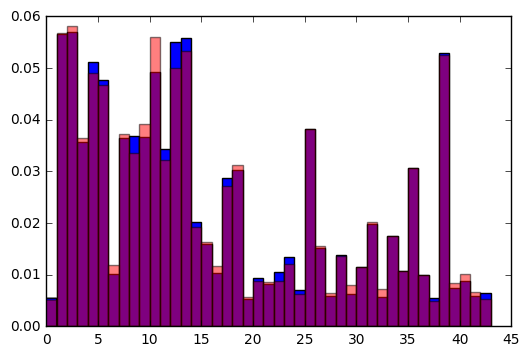

In [9]:
unique, counts = np.unique(y_train, return_counts=True)
unique_valid, counts_valid = np.unique(y_valid, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

print(dict(zip(unique, counts)))
plt.hist(y_train, color = 'b', label = 'train', normed = True, bins=range(n_classes+1))
plt.hist(y_valid, color = 'r', alpha = 0.5, label = 'test', normed = True, bins=range(n_classes+1))
#plt.hist(y_test, color = 'r', alpha = 0.5, label = 'test', normed = True, bins=range(n_classes+1))
plt.show()


### Plot examples of traffic signs for each class

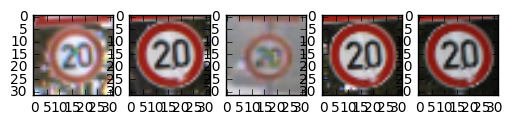

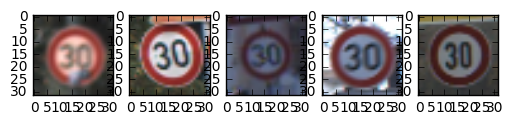

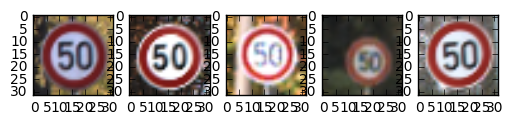

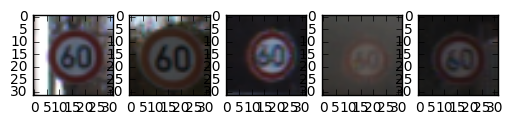

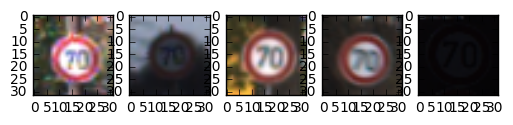

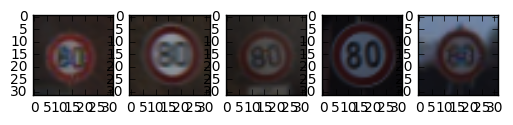

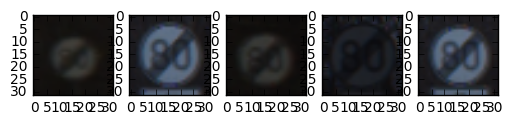

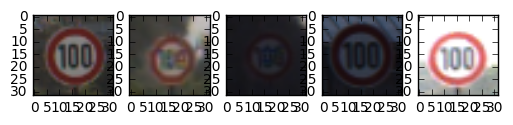

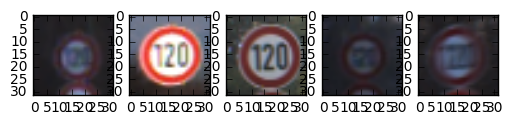

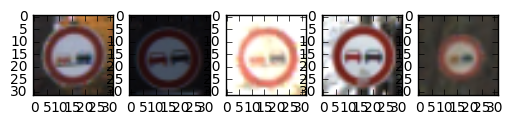

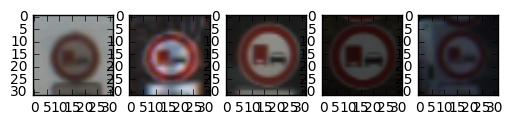

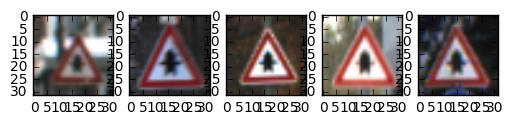

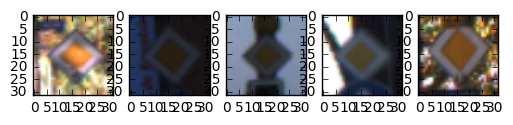

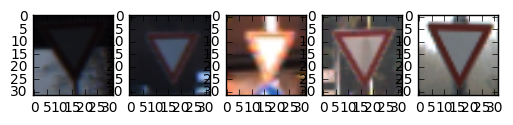

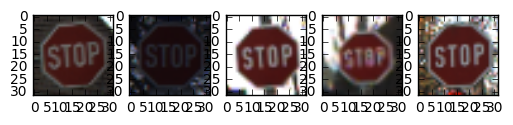

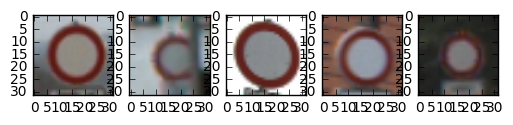

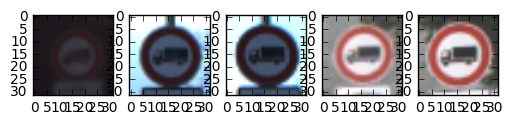

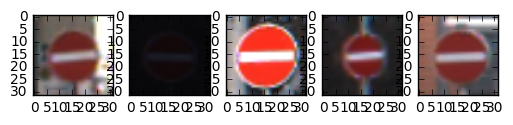

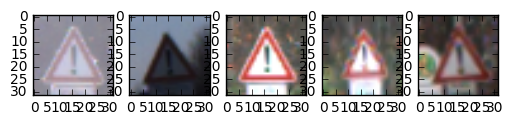

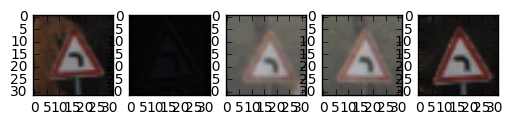

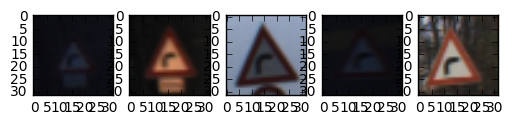

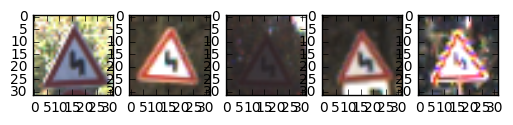

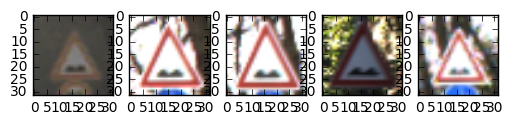

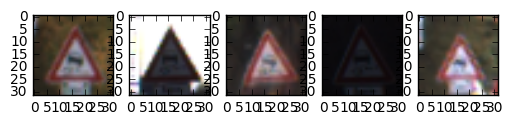

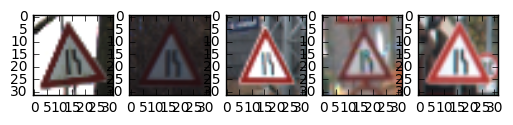

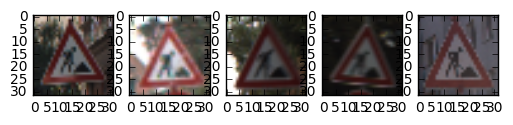

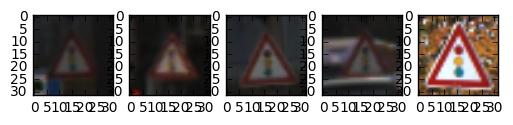

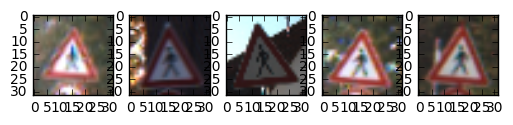

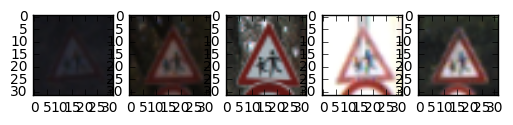

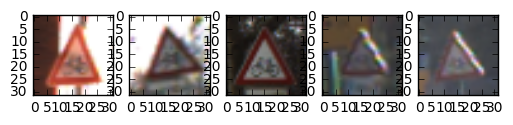

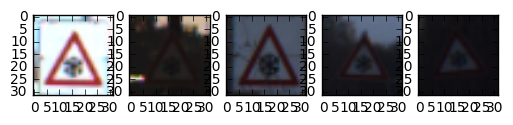

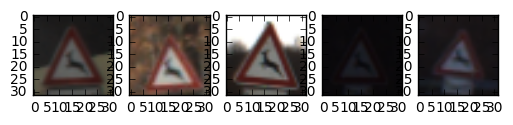

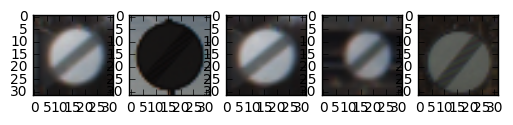

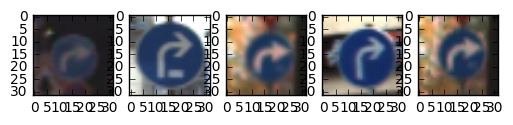

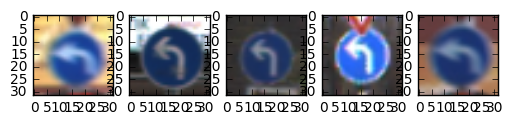

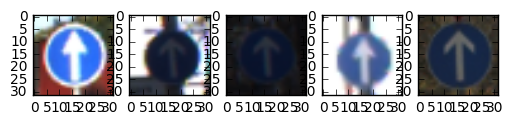

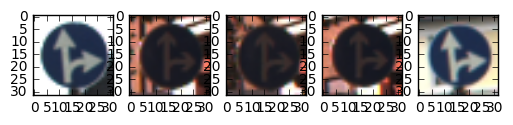

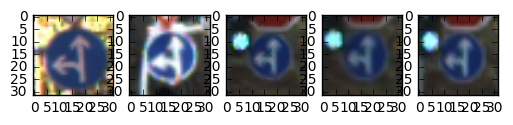

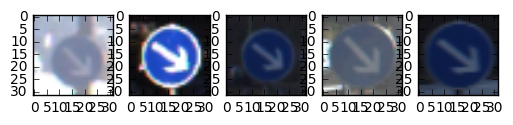

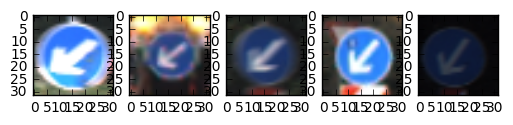

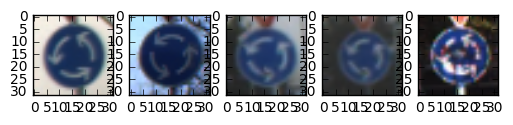

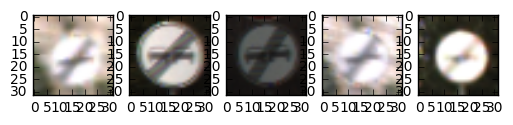

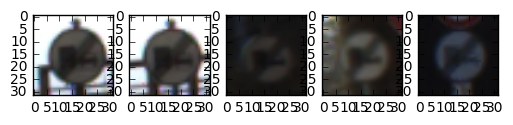

In [10]:
y = pd.DataFrame(y_train)
y.columns = ['class']
y['index'] = y.index

gb = y.groupby(['class'])
#print(gb['index'].agg([np.min,np.max]))

num_image = 5
for c in range(n_classes):
    # filter 
    yf = y[y['class']== c].sample(num_image)
    idx = (yf['index'])
    fig = plt.figure()
    for i in range(num_image):
        a=fig.add_subplot(1,num_image,i+1)
        plt.imshow(X_train[idx][i])
    plt.show()
    


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Preprocess the data here.

In [10]:
num_channels = 1
image_size = X_train.shape[1]


### Convert to gray scale

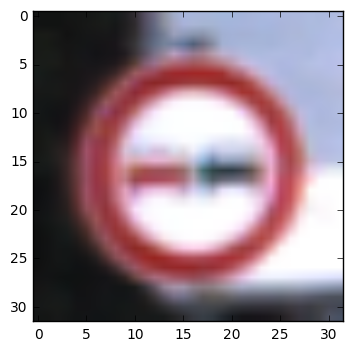

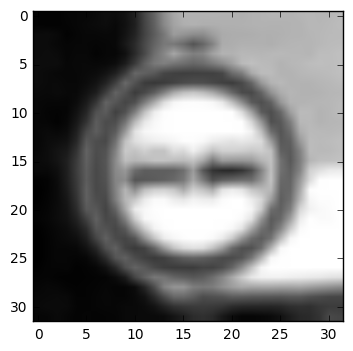

In [11]:
def convert_to_gray_scale(X, b = [0.299,0.587,0.114]):
    return np.inner(X, b)

# plot in color
plt.imshow(X_train[0])
plt.show()

X_train = convert_to_gray_scale(X_train)
X_valid = convert_to_gray_scale(X_valid)
X_test = convert_to_gray_scale(X_test)

# plot same image in gray scale
plt.imshow(X_train[0], cmap='gray')
plt.show()

### Reformat and one-hot encoding

In [12]:
def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)

  labels = (np.arange(n_classes) == labels[:,None]).astype(np.float32)
  return dataset, labels

X_train, y_train = reformat(X_train, y_train)
X_valid, y_valid = reformat(X_valid, y_valid)
X_test, y_test = reformat(X_test, y_test)

print('Features set', X_train.shape, X_valid.shape, X_test.shape)
print('Labels set', y_train.shape, y_valid.shape, y_test.shape)

Features set (27446, 32, 32, 1) (11763, 32, 32, 1) (12630, 32, 32, 1)
Labels set (27446, 43) (11763, 43) (12630, 43)


### Normalize pixel values between 0 and 1

In [13]:
#X_train[0]

In [14]:
def pixel_normalization(dataset):
    return dataset/255 - 0.5

X_train = pixel_normalization(X_train)
X_valid = pixel_normalization(X_valid)
X_test = pixel_normalization(X_test)


In [15]:
X_valid.shape

(11763, 32, 32, 1)

### functions to help run graph

In [16]:
def batches(batch_size, features, labels):
    """
    Create batches of features and labels
    :param batch_size: The batch size
    :param features: List of features
    :param labels: List of labels
    :return: Batches of (Features, Labels)
    """
    assert len(features) == len(labels)
    output_batches = []
    
    sample_size = len(features)
    for start_i in range(0, sample_size, batch_size):
        end_i = start_i + batch_size
        batch = [features[start_i:end_i], labels[start_i:end_i]]
        output_batches.append(batch)
        
    return output_batches


In [17]:
def accuracy_func(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])


### If we want to downsample even more to see if we can easily overfit the data

In [18]:
print(X_train.shape)
X_train_subset = X_train#[0:20,:,:,:]
y_train_subset = y_train#[0:20,:]
print(X_train_subset.shape)
print(y_train_subset.shape)

y_train_subset[0]
n_values = np.argmax(y_train, axis=1)
print(max(n_values))

(27446, 32, 32, 1)
(27446, 32, 32, 1)
(27446, 43)
42


In [19]:
def variable_summaries(var, name):
  """Attach a lot of summaries to a Tensor."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.scalar_summary('mean/' + name, mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.scalar_summary('stddev/' + name, stddev)
    tf.scalar_summary('max/' + name, tf.reduce_max(var))
    tf.scalar_summary('min/' + name, tf.reduce_min(var))
    tf.histogram_summary(name, var)

In [20]:

learning_rate = 0.05
std = 0.1

graph = tf.Graph()

tf.reset_default_graph()

with graph.as_default():
    
    # Create basic cnn
    # x = tf.pad(x, [[0, 0], [2, 2], [2, 2], [0, 0]], mode="CONSTANT")

    tf_train_dataset = tf.placeholder(tf.float32, 
                          shape=[None, image_size, image_size, num_channels])
    tf_train_labels = tf.placeholder(tf.float32, 
                          shape=[None, n_classes])

    #n_val = tf.placeholder(tf.float32, 
    #                      shape=[None, ])
    
    tf_train_all_dataset = tf.constant(X_train_subset)
    tf_valid_dataset = tf.constant(X_valid)
    tf_test_dataset = tf.constant(X_test)
    
    tf_beta = tf.placeholder(tf.float32)
    tf_keep_prob = tf.placeholder(tf.float32)
    
    layer_width = {
        'conv_layer_1': 32,
        'conv_layer_2': 54,
        'fully_connected': 1024,
        'fully_connected_2': 256
    }

    weights = {'conv_layer_1': tf.Variable(tf.truncated_normal([5, 5, num_channels, layer_width['conv_layer_1']], stddev = std)),
              'conv_layer_2': tf.Variable(tf.truncated_normal([5, 5, layer_width['conv_layer_1'], layer_width['conv_layer_2']], stddev = std)),
              'fully_connected' : tf.Variable(tf.truncated_normal([486,1024], stddev = std)),
              'fully_connected_2' : tf.Variable(tf.truncated_normal([1024,256], stddev = std)),
              'out': tf.Variable(tf.truncated_normal([layer_width['fully_connected_2'], n_classes], stddev = std)),
              }
    
    biases = {'conv_layer_1': tf.Variable(tf.zeros(layer_width['conv_layer_1'])),
              'conv_layer_2': tf.Variable(tf.zeros(layer_width['conv_layer_2'])),
              'fully_connected': tf.Variable(tf.zeros(layer_width['fully_connected'])),
              'fully_connected_2': tf.Variable(tf.zeros(layer_width['fully_connected_2'])),
              'out': tf.Variable(tf.zeros(n_classes))
              }

    
    
    #def model(data1, keep_prob):
    # 32x32x1
    #data = tf_train_dataset
    #Convolution layer 1. The output shape should be 28x28x6.
    with tf.name_scope("First_conv_layer"):
        variable_summaries(weights['conv_layer_1'], 'First_conv_layer' + '/weights')
        variable_summaries(biases['conv_layer_1'], 'First_conv_layer' + '/biases')
        conv_layer_1 = tf.nn.conv2d(tf_train_dataset, weights['conv_layer_1'], strides = [1,1,1,1], padding = 'VALID', name="Conv1")
        tf.histogram_summary('First_conv_layer' + '/pre_activations', conv_layer_1)
        conv_layer_1 = tf.nn.relu(conv_layer_1, name="Relu1")
        tf.histogram_summary('First_conv_layer' + '/activations', conv_layer_1)
        #conv_layer_1 = tf.nn.dropout(conv_layer_1, keep_prob)
        #Pooling layer 1. The output shape should be 14x14x6.
    
    with tf.name_scope("Max_pool_layer_1"):
        layer_1 = tf.nn.max_pool(conv_layer_1,ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1],padding='VALID', name="MaxPool1")
        tf.histogram_summary('Max_pool_layer_1' + '/activations', layer_1)
        
    with tf.name_scope("Second_conv_layer"):
        #Convolution layer 2. The output shape should be 10x10x16.
        variable_summaries(weights['conv_layer_2'], 'Second_conv_layer' + '/weights')
        variable_summaries(biases['conv_layer_2'], 'Second_conv_layer' + '/biases')
        conv_layer_2 = tf.nn.conv2d(layer_1, weights['conv_layer_2'], strides = [1,2,2,1], padding = 'SAME', name="Conv2")
        tf.histogram_summary('Second_conv_layer' + '/pre_activations', conv_layer_2)
        conv_layer_2 = tf.nn.relu(conv_layer_2, name="Relu2")
        tf.histogram_summary('Second_conv_layer' + '/activations', conv_layer_2)
        #conv_layer_2 = tf.nn.dropout(conv_layer_2, keep_prob)
        #Pooling layer 2. The output shape should be 5x5x16.
    
    with tf.name_scope("Max_pool_layer_2"):
        layer_2 = tf.nn.max_pool(conv_layer_2,ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1],padding='VALID', name="MaxPool2")
        tf.histogram_summary('Max_pool_layer_2' + '/activations', layer_2)

    # Fully connected
    with tf.name_scope("Flatten"):
        fc = tf.contrib.layers.flatten(layer_2) # (5 * 5 * 16, 120)
        fc_shape = (fc.get_shape().as_list()[-1], layer_width['fully_connected'])
        print(fc_shape)
            #weights['fully_connected'] = tf.Variable(tf.truncated_normal(shape=(fc_shape), stddev = 0.1))

    with tf.name_scope("Fully_Connected_layer_1"):
        fc1 = tf.add(tf.matmul(fc, weights['fully_connected'], name="FC1_mult"), biases['fully_connected'], name = "FC1Sum")
        tf.histogram_summary('Fully_Connected_layer_1' + '/pre_activations', fc1)
        fc1 = tf.nn.relu(fc1, name = "reluFC1")
        tf.histogram_summary('Fully_Connected_layer_1' + '/activations', fc1)
        
    with tf.name_scope("Fully_Connected_layer_2"):
        fc2 = tf.add(tf.matmul(fc1, weights['fully_connected_2'], name="FC2_mult"), biases['fully_connected_2'], name = "FC2Sum")
        tf.histogram_summary('Fully_Connected_layer_2' + '/pre_activations', fc2)
        fc2 = tf.nn.relu(fc2, name = "reluFC2")
        tf.histogram_summary('Fully_Connected_layer_2' + '/activations', fc2)

    # Out
    with tf.name_scope("Logits"):
        logits = tf.add(tf.matmul(fc2, weights['out'], name="out_mult"), biases['out'], name = "out_sum")
        tf.histogram_summary('logits' + '/pre_activations', logits)
        train_prediction = tf.nn.softmax(logits) 
        tf.histogram_summary('logits' + '/activations', train_prediction)
        
    #logits = model(tf_train_dataset, keep_prob = 0.5) #tf.matmul(fc1, weights['out']) +  biases['out'] #
    # Optimization

    
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
                            + tf_beta * 1/2 * tf.nn.l2_loss(weights['conv_layer_1'])
                            + tf_beta * 1/2 * tf.nn.l2_loss(weights['conv_layer_2'])
                            + tf_beta * 1/2 * tf.nn.l2_loss(weights['out'])
                            + tf_beta * 1/2 * tf.nn.l2_loss(weights['fully_connected'])
                             ) #sparse_softmax_cross_entropy_with_logits if y is not one-hot encoded    
        tf.scalar_summary('loss', loss)

    with tf.name_scope('train'):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
    #tf.summary.scalar('loss', loss)
    #merged = tf.summary.merge_all()
    #accuracy_summary = tf.scalar_summary("accuracy", accuracy)
    #loss_summary = tf.scalar_summary("loss", loss)
    
    
    
    #histogram_summary = tf.histogram_summary('histogram', weights['out'])
    #loss_2_summary = tf.scalar_summary("loss", loss)
    #merged = tf.merge_summary([loss_summary,histogram_summary])
    
    #n_val = tf.argmax(tf_train_labels,1)
    #n_val = tf.cast(n_val, tf.float32)
    
    #Calculate accuracy
    #correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(tf_train_labels, 1))
    #correct_prediction = tf.equal(np.mean(Yte_predict == tf_train_labels))
    #accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    
    #valid_prediction = tf.nn.softmax(model(data1 = tf_valid_dataset, keep_prob = 1.0))
    #test_prediction = tf.nn.softmax(model(data = tf_test_dataset, keep_prob = 1.0))

    #weights1 = weights['conv_layer_1'][0]
    # Merge all the summaries and write them out to /tmp/mnist_logs (by default)
    
    with tf.name_scope('accuracy'):
        with tf.name_scope('correct_prediction'):
          correct_prediction = tf.equal(tf.argmax(train_prediction, 1), tf.argmax(tf_train_labels, 1))
        with tf.name_scope('accuracy'):
          accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
          #tf.summary.scalar('accuracy1', accuracy1)
          tf.scalar_summary('accuracy', accuracy)
    
    merged = tf.merge_all_summaries()
    

(486, 1024)


In [21]:
#print(X_train_subset[0,:,:,0])
#print(X_train_subset[0,:,:,1])
#print(X_train_subset[0,:,:,2])

###########
#print('1')
#print(X_train_subset[1,:,:,0])
#print(X_train_subset[1,:,:,1])
#print(X_train_subset[1,:,:,2])
#y_train_subset

In [22]:
#print(np.unique(np.argmax(y_valid_subset, axis=1)))
print(np.unique(np.argmax(y_train_subset, axis=1)))
#print(np.unique(np.argmax(y_test_subset, axis=1)))
#print(y_train_subset)
print(np.argmax(y_train_subset, axis=1))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
[ 9 22  2 ..., 25 18 31]


In [23]:
# Run it:

epochs = 1
batch_size = 64
beta = 0.005

with tf.Session(graph = graph) as session:
    #tf.initialize_all_variables().run()
    
    train_writer = tf.train.SummaryWriter('log-directory/train',
                                          session.graph)
    valid_writer = tf.train.SummaryWriter('log-directory/valid')
    
    step = 0
    session.run(tf.initialize_all_variables())
    for epoch in range(epochs):
        
        for batch_features, batch_labels in batches(batch_size, X_train_subset, y_train_subset):
            step += 1
            #batch_n_val = np.argmax(batch_labels, axis=1).astype(np.float32)
            feed_dict = {tf_train_dataset : batch_features, tf_train_labels : batch_labels, tf_beta: beta, tf_keep_prob : 0.5} #n_val : batch_n_val, 
            
            if step % 10 == 0:  # Record summaries and test-set accuracy
                feed_dict_valid = {tf_train_dataset : X_valid, tf_train_labels : y_valid, tf_beta: beta, tf_keep_prob : 1.0} #n_val : batch_n_val,
                summary, acc, l = session.run([merged, accuracy, loss], feed_dict=feed_dict_valid)
                valid_writer.add_summary(summary, step)
                print('Validation accuracy at step %s: %s' % (step, acc))
                
            else:
                if step % 100 == 99: 
                    run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                    run_metadata = tf.RunMetadata()
                    _, summary = session.run([optimizer, merged],
                                          feed_dict=feed_dict,
                                          options=run_options,
                                          run_metadata=run_metadata)
                    train_writer.add_run_metadata(run_metadata, 'step%03d' % step)
                    train_writer.add_summary(summary, step)
                    print('Adding run metadata for', step)
                else:
                    summary, _ = session.run([optimizer, merged], feed_dict=feed_dict)
                    train_writer.add_summary(summary, step)
                    
                    
                
                  #print("_____________")
                  #print("Minibatch loss at step %d: %f" % (step, l))
                  #print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                  #print("acc:", acc)
                  
                
                  #print("Validation accuracy: %.1f%%" % accuracy(
                  # valid_prediction.eval(), y_valid)) # label_test => valid_labels
                  
                  #print("mini batch labels: ", (np.argmax(batch_labels, axis=1)))
                    
    train_writer.close()   
    valid_writer.close()   
    
    
    #print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), y_test)) # label_test => test_labels



Validation accuracy at step 10: 0.0779563
Validation accuracy at step 20: 0.0796565
Validation accuracy at step 30: 0.0949588
Validation accuracy at step 40: 0.13653
Validation accuracy at step 50: 0.164244
Validation accuracy at step 60: 0.174445
Validation accuracy at step 70: 0.213806
Validation accuracy at step 80: 0.227918
Validation accuracy at step 90: 0.193403
Adding run metadata for 99
Validation accuracy at step 100: 0.23914
Validation accuracy at step 110: 0.246961
Validation accuracy at step 120: 0.268214
Validation accuracy at step 130: 0.296098
Validation accuracy at step 140: 0.327978
Validation accuracy at step 150: 0.310805
Validation accuracy at step 160: 0.361557
Validation accuracy at step 170: 0.301539
Validation accuracy at step 180: 0.37941
Validation accuracy at step 190: 0.346085
Adding run metadata for 199
Validation accuracy at step 200: 0.391992
Validation accuracy at step 210: 0.426337
Validation accuracy at step 220: 0.440024
Validation accuracy at step 23

In [28]:
!tensorboard --logdir=log-directory

Starting TensorBoard b'29' on port 6006
127.0.0.1 - - [18/Dec/2016 22:54:56] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Dec/2016 22:54:56] "GET /webcomponentsjs/webcomponents-lite.min.js HTTP/1.1" 200 -
127.0.0.1 - - [18/Dec/2016 22:54:56] "GET /lib/css/global.css HTTP/1.1" 200 -
127.0.0.1 - - [18/Dec/2016 22:54:56] code 404, message Not Found
127.0.0.1 - - [18/Dec/2016 22:54:56] "GET /dist/bazel-html-imports.html HTTP/1.1" 404 -
127.0.0.1 - - [18/Dec/2016 22:54:56] "GET /dist/tf-tensorboard.html HTTP/1.1" 200 -
127.0.0.1 - - [18/Dec/2016 22:54:56] "GET /paper-dialog/paper-dialog.html HTTP/1.1" 200 -
127.0.0.1 - - [18/Dec/2016 22:54:56] "GET /paper-checkbox/paper-checkbox.html HTTP/1.1" 200 -
127.0.0.1 - - [18/Dec/2016 22:54:56] "GET /polymer/polymer.html HTTP/1.1" 200 -
127.0.0.1 - - [18/Dec/2016 22:54:56] "GET /iron-icons/iron-icons.html HTTP/1.1" 200 -
127.0.0.1 - - [18/Dec/2016 22:54:56] "GET /paper-tabs/paper-tabs.html HTTP/1.1" 200 -
127.0.0.1 - - [18/Dec/2016 22:54:56] "GET /paper

In [ ]:
# 3. Are there any duplicates? Like all black pictures / all whites ?

In [ ]:
# Additional data by rotating image?

In [ ]:
# Number of examples per label 

In [ ]:
# Dropout / mini-batch / 

In [ ]:
# 3. What metric to use: logloss

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [ ]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.